In [1]:
import os
from sys import argv
from argparse import ArgumentParser
from datasets import load_dataset
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer, BertConfig, EarlyStoppingCallback
import torch
from torch.nn.functional import softmax
from sklearn.metrics import f1_score, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

parser = ArgumentParser()
parser.add_argument("--output_directory", type=str)
parser.add_argument("--language", type=str)
parser.add_argument("--context_length", type=int, default=128)
parser.add_argument("--cache_dir", type=str, default=".")
args, _ = parser.parse_known_args(argv[1:])
DIRECTORY = args.output_directory

# Constants for model testing
LABELS = ["anger", "fear", "joy", "sadness", "surprise"]
THRESHOLD = 0.5


In [2]:
# Preprocess and tokenise data
def prepare_data(rows):
    labels = list(zip(
        rows["anger"], 
        rows["fear"], 
        rows["joy"], 
        rows["sadness"], 
        rows["surprise"]
    ))
    labels = [[float(label) for label in example] for example in labels]
    tokenized_data = tokenizer(rows["text"], truncation=True, padding="max_length")
    tokenized_data["labels"] = labels
    return tokenized_data


# Compute metrics for evaluation: f1, accuracy 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    f1 = f1_score(labels, predictions, average="micro")
    accuracy = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": accuracy}


# Label the prediction after prediction
def label_prediction(prediction):
    labeled = []
    for pred in prediction:
        labeled.append([LABELS[i] for i, label in enumerate(pred) if label == 1])
    return labeled


In [3]:
dataset = load_dataset("csv", data_files="public_data_dev/track_a/train/eng.csv")
tokenizer = BertTokenizer.from_pretrained("bert-large-cased")

# Split the dataset into train and test set
split_dataset = dataset["train"].train_test_split(test_size=0.2, shuffle=True)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Apply preprocessing and tokenisation
tokenized_train = train_dataset.map(prepare_data, batched=True)
tokenized_train = tokenized_train.remove_columns(["id", "text", "anger", "fear", "joy", "sadness", "surprise"])

# Apply preprocessing and tokenisation
tokenized_test = test_dataset.map(prepare_data, batched=True)
tokenized_test = tokenized_test.remove_columns(["id", "text", "anger", "fear", "joy", "sadness", "surprise"])


Map:   0%|          | 0/2214 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

In [4]:
# Get the pretrained model and start fine-tuning
model = BertForSequenceClassification.from_pretrained(
    "bert-large-cased", 
    num_labels=5, 
    problem_type="multi_label_classification", 
    hidden_dropout_prob=0.2,  
    attention_probs_dropout_prob=0.2
)

training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=3e-5,
    num_train_epochs=15,
    logging_dir="./logs_large_modezl",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=2,
    lr_scheduler_type="linear",
    warmup_steps=1000,
    logging_steps=50,
    load_best_model_at_end = True,
    save_total_limit=3,
    weight_decay=0.01,
    max_grad_norm=1.0,
    fp16=True,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

result = trainer.evaluate()
print("Fine-tuned model results:", result)

# trainer.save_model(f"{DIRECTORY}/bert_large_proj")
# trainer.save_model("model/bert_large_SemEval")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.746100,0.719822,0.470005,0.095668
2,0.693100,0.562122,0.463989,0.166065
3,0.543800,0.481162,0.569415,0.277978
4,0.466800,0.401432,0.703611,0.416968
5,0.361900,0.365527,0.735646,0.445848
6,0.316200,0.338981,0.755422,0.471119
7,0.290700,0.332626,0.759064,0.467509
8,0.215700,0.352650,0.754157,0.487365
9,0.182400,0.351460,0.768421,0.472924


Fine-tuned model results: {'eval_loss': 0.3326261639595032, 'eval_f1': 0.7590643274853801, 'eval_accuracy': 0.4675090252707581, 'eval_runtime': 2.1128, 'eval_samples_per_second': 262.214, 'eval_steps_per_second': 16.566, 'epoch': 9.0}


In [5]:
# Evaluation phase
model.eval()

text = "Colorado , middle of nowhere ."
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits

probabilities = torch.sigmoid(logits).cpu().numpy()
prediction = (probabilities > THRESHOLD).astype(int)
emotion = label_prediction(prediction)

print(
    "Probabilities: {}".format(probabilities),
    "Predictions: {}".format(prediction),
    "Emotion: {}".format(emotion), sep='\n'
)

Probabilities: [[0.06153674 0.91715443 0.04501553 0.16940586 0.93991333]]
Predictions: [[0 1 0 0 1]]
Emotion: [['fear', 'surprise']]


In [17]:
# %pip install --upgrade shap
# %pip install numpy==2.1

Device set to use cuda:0
/root/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


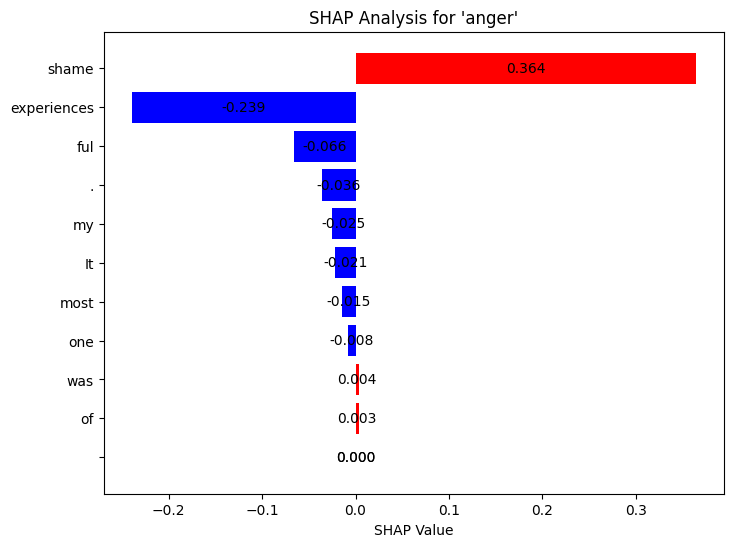

In [6]:
import transformers
import shap
import numpy as np
import matplotlib.pyplot as plt

shap_dataset = dataset["train"]["text"][:3]
class_names = ["anger", "fear", "joy", "sadness", "surprise"]

pred = transformers.pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
)

explainer = shap.Explainer(pred, output_names=class_names)
shap_values = explainer(shap_dataset)


single_shap = shap_values[2]
class_index = 0
shap_values_array = np.array(single_shap.values[:, class_index])
feature_names = single_shap.feature_names

sorted_indices = np.argsort(np.abs(shap_values_array))[::-1]
shap_values_array = shap_values_array[sorted_indices]
feature_names = np.array(feature_names)[sorted_indices]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(feature_names, shap_values_array, color=["red" if v > 0 else "blue" for v in shap_values_array])

for bar, value in zip(bars, shap_values_array):
    ax.text(bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.3f}", 
            ha="center", va="center")

ax.set_xlabel("SHAP Value")
ax.set_title(f"SHAP Analysis for '{class_names[class_index]}'")
plt.gca().invert_yaxis()
plt.show()

In [96]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'anger', 'fear', 'joy', 'sadness', 'surprise'],
        num_rows: 2768
    })
})